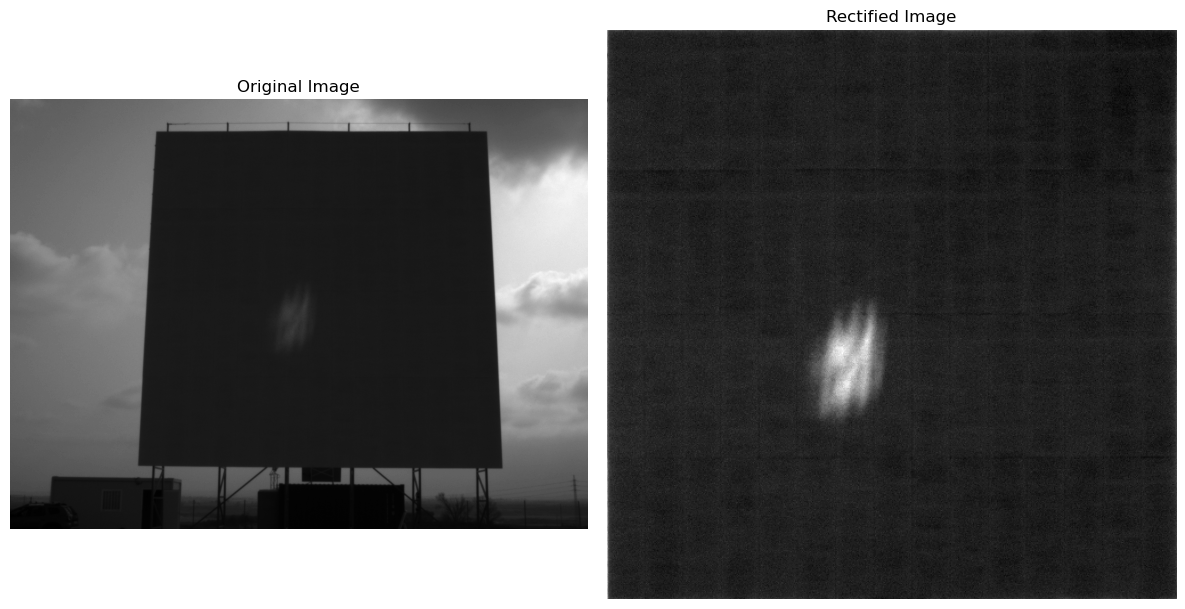

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from skimage.filters import threshold_yen
from skimage.measure import label, regionprops
import cv2

# comparing different processing methods for beam center calculation for the artificial image
# Not interested for automatically finding the target corners, just picking the corners manually


# image_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\PSA-CIEMAT\data\Test tracking H1605 to BCS people"
# image_file_name = "H1605 TRK 24-01-2025 Start_11.57.00 End_15.57.37 Frames-48 TFOV.tif"
artificial_image_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\ArtificialImages"
sub_folder = "result0cener"
image_name = "superposed_AA39_raw.png"
corner_file_name = "corner_locations.csv"
corner_file_location = os.path.join("Artificial_image_processing", corner_file_name)

image_file_path = os.path.join(artificial_image_folder, sub_folder, image_name)
images = imread(image_file_path)

def crop_and_rectify(corner_file:str, img_name:str, width:int=1000, height:int=1000):
    corner_df = pd.read_csv(corner_file, index_col=0)
    img_base_name = os.path.basename(img_name)
    img = imread(img_name)
    corner_data = corner_df.loc[img_base_name]
    upper_left_x = int(corner_data['ULX'])
    upper_left_y = int(corner_data['ULY'])
    upper_right_x = int(corner_data['URX'])
    upper_right_y = int(corner_data['URY'])
    lower_left_x = int(corner_data['LLX'])
    lower_left_y = int(corner_data['LLY'])
    lower_right_x = int(corner_data['LRX'])
    lower_right_y = int(corner_data['LRY'])

    # perspective transform the locations within the corners to a rectangle described by width and height
    src_points = np.array([[upper_left_x, upper_left_y],
                           [upper_right_x, upper_right_y],
                           [lower_left_x, lower_left_y],
                           [lower_right_x, lower_right_y]], dtype=np.float32)
    
    dst_points = np.array([[0, 0],
                           [width, 0],
                           [0, height],
                           [height, width]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    rectified_img = cv2.warpPerspective(img, M, (width, height))
    return rectified_img
    


rectified_img = crop_and_rectify(corner_file=corner_file_location,
                  img_name=image_file_path,
                  width=500, height=500)

# Do 1x2 subplot to show the original and rectified image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rectified_img, cmap='gray')
plt.title("Rectified Image")
plt.axis('off')
plt.tight_layout()
plt.show()


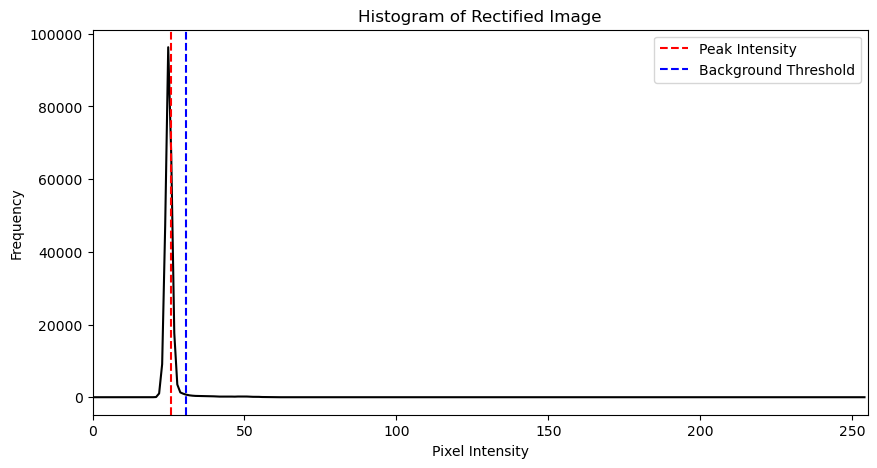

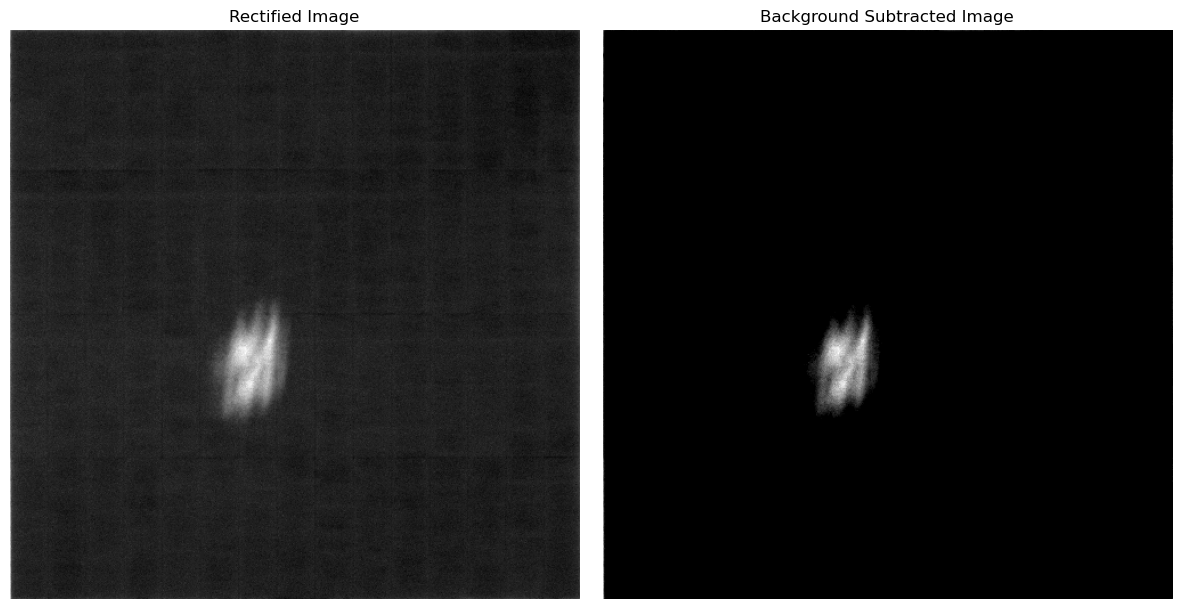

In [2]:
# remove the darker background determined by histogram

# normalize the image first
hist, bin_edges = np.histogram(rectified_img.flatten(), bins=256, range=(0, 255))
peak_idx = np.argmax(hist)
peak_bin_right = bin_edges[peak_idx + 1]
background_threshold = peak_bin_right + 5
# plot the histogram
plt.figure(figsize=(10, 5))
plt.plot(bin_edges[:-1], hist, color='black')
plt.title("Histogram of Rectified Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.xlim([0, 255])

# mark the peak and background threshold
plt.axvline(x=peak_bin_right, color='red', linestyle='--', label='Peak Intensity')
plt.axvline(x=background_threshold, color='blue', linestyle='--', label='Background Threshold')
plt.legend()    
plt.show()



# subtract the background
rectified_image_float = rectified_img.astype(np.float32)
rectified_image_float -= background_threshold
# clip the values to be in the range [0, 255]
rectified_image_float = np.clip(rectified_image_float, 0, 255)
# convert back to uint8
rectified_image_uint8 = rectified_image_float.astype(np.uint8)

# Do 1x2 subplot to show the original and background subtracted image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rectified_img, cmap='gray')
plt.title("Rectified Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rectified_image_uint8, cmap='gray')
plt.title("Background Subtracted Image")
plt.axis('off')
plt.tight_layout()
plt.show()



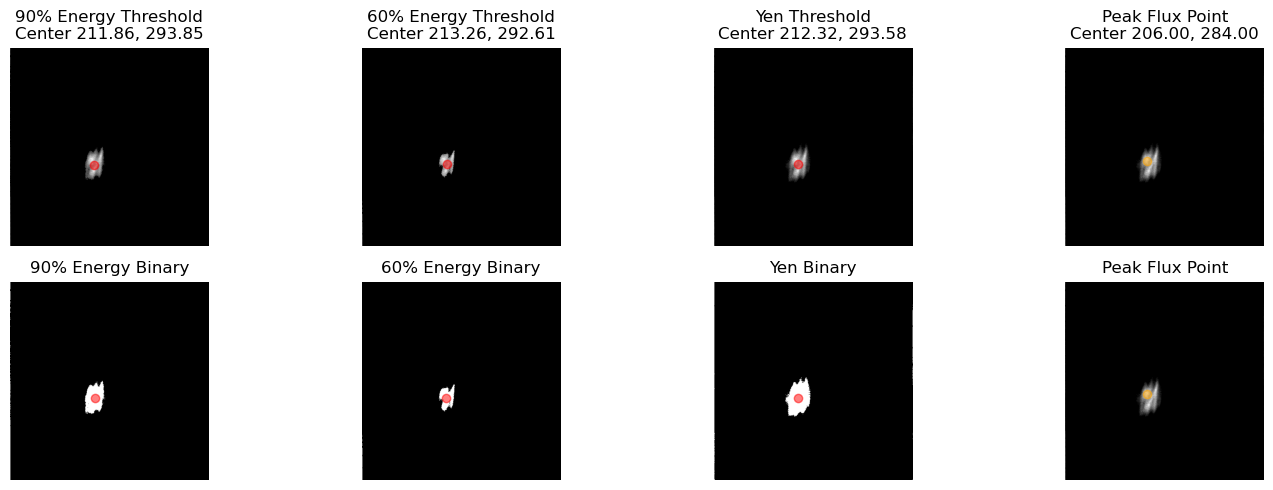

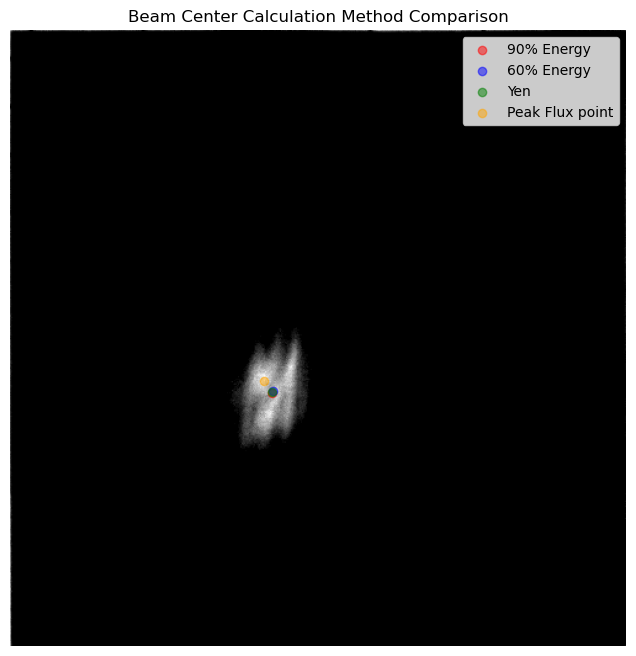

In [3]:
def find_theshold_with_energy(img_input, energy_level):
    sorted_data = np.sort(img_input.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_data)
    total_sum = cumulative_sum[-1]
    threshold_index = np.searchsorted(cumulative_sum, total_sum * energy_level / 100.0)
    threshold_value = sorted_data[threshold_index]
    return threshold_value

def find_centroid(img_input, bright_spot_threshold):
    regionprops_list = regionprops(label(img_input > bright_spot_threshold), 
                                            intensity_image=img_input)
    sorted_regionprops = sorted(regionprops_list, key=lambda x: x.area, reverse=True)

    beam_center_pixel = sorted_regionprops[0].centroid
    return beam_center_pixel

threshold_yen = threshold_yen(rectified_image_uint8)
threshold_90 = find_theshold_with_energy(rectified_image_uint8, 90)
threshold_60 = find_theshold_with_energy(rectified_image_uint8, 60)

img_threshold_90_binary = rectified_image_uint8 > threshold_90
img_threshold_60_binary = rectified_image_uint8 > threshold_60
img_threshold_yen_binary = rectified_image_uint8 > threshold_yen
img_threhsold_90 = rectified_image_uint8.copy()
img_threhsold_90[~img_threshold_90_binary] = 0
img_threhsold_90_center = find_centroid(rectified_image_uint8, threshold_90)
img_threhsold_60 = rectified_image_uint8.copy()
img_threhsold_60[~img_threshold_60_binary] = 0
img_threhsold_60_center = find_centroid(rectified_image_uint8, threshold_60)
img_threshold_yen = rectified_image_uint8.copy()
img_threshold_yen[~img_threshold_yen_binary] = 0
img_threshold_yen_center = find_centroid(rectified_image_uint8, threshold_yen)

img_max_val = np.max(rectified_image_uint8)
(y_max, x_max) = np.where(rectified_image_uint8 == img_max_val)
y_max = y_max[0]
x_max = x_max[0]




fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax[0, 0].imshow(img_threhsold_90, cmap="gray")
ax[0, 0].scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="90% Energy", color="red", alpha=0.5)
ax[0, 0].set_title(f"90% Energy Threshold\nCenter {img_threhsold_90_center[1]:.2f}, {img_threhsold_90_center[0]:.2f}")
ax[0, 1].imshow(img_threhsold_60, cmap="gray")
ax[0, 1].scatter(img_threhsold_60_center[1],img_threhsold_60_center[0], label="60% Energy", color="red", alpha=0.5)
ax[0, 1].set_title(f"60% Energy Threshold\nCenter {img_threhsold_60_center[1]:.2f}, {img_threhsold_60_center[0]:.2f}")
ax[1, 0].imshow(img_threshold_90_binary, cmap="gray")
ax[1, 0].scatter(img_threhsold_60_center[1],img_threhsold_60_center[0], label="90% Energy Binary", color="red", alpha=0.5)
ax[1, 0].set_title("90% Energy Binary")
ax[1, 1].imshow(img_threshold_60_binary, cmap="gray")
ax[1, 1].scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="60% Energy Binary", color="red", alpha=0.5)
ax[1, 1].set_title("60% Energy Binary")
ax[0, 2].imshow(img_threshold_yen, cmap="gray")
ax[0, 2].scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen Threshold", color="red", alpha=0.5)
ax[0, 2].set_title(f"Yen Threshold\nCenter {img_threshold_yen_center[1]:.2f}, {img_threshold_yen_center[0]:.2f}")
ax[1, 2].imshow(img_threshold_yen_binary, cmap="gray")
ax[1, 2].scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen Binary", color="red", alpha=0.5)
ax[1, 2].set_title("Yen Binary")
ax[0, 3].imshow(rectified_image_uint8, cmap="gray")
ax[0, 3].scatter(x_max, y_max, label="Peak Flux point", color="orange", alpha=0.5)
ax[0, 3].set_title(f"Peak Flux Point\nCenter {x_max:.2f}, {y_max:.2f}")
ax[1, 3].imshow(rectified_image_uint8, cmap="gray")
ax[1, 3].scatter(x_max, y_max, label="Peak Flux point", color="orange", alpha=0.5)    
ax[1, 3].set_title("Peak Flux Point")
# turn off axis
for i in range(2):
    for j in range(4):
        ax[i, j].axis("off")

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 8))
plt.imshow(rectified_image_uint8, cmap="gray")
plt.scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="90% Energy", color="red", alpha=0.5)
plt.scatter(img_threhsold_60_center[1], img_threhsold_60_center[0], label="60% Energy", color="blue", alpha=0.5)
plt.scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen", color="green", alpha=0.5)
plt.scatter(x_max, y_max, label="Peak Flux point", color="orange", alpha=0.5)
plt.title("Beam Center Calculation Method Comparison")
plt.xlabel("X (px)")
plt.ylabel("Y (px)")
plt.legend()
# turn off axis
plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
def calculate_azimuth_and_elevation_error(ideal_vector, actual_vector):
    """
    Calculate the azimuth and elevation errors between two 3D vectors.

    Args:
        ideal_vector (numpy.ndarray): Ideal pointing vector (3D).
        actual_vector (numpy.ndarray): Actual pointing vector (3D).

    Returns:
        tuple: (azimuth_error, elevation_error) in radians.
    """
    # Normalize the vectors
    ideal_vector = ideal_vector / np.linalg.norm(ideal_vector)
    actual_vector = actual_vector / np.linalg.norm(actual_vector)

    # Calculate azimuth angles (in radians)
    ideal_azimuth = np.arctan2(ideal_vector[1], ideal_vector[0])
    actual_azimuth = np.arctan2(actual_vector[1], actual_vector[0])
    azimuth_error = actual_azimuth - ideal_azimuth

    # Calculate elevation angles (in radians)
    ideal_elevation = np.arcsin(ideal_vector[2])
    actual_elevation = np.arcsin(actual_vector[2])
    elevation_error = actual_elevation - ideal_elevation

    return azimuth_error*1000, elevation_error*1000


# generate a pandas dataframe
x_center = rectified_image_uint8.shape[1] / 2
y_center = rectified_image_uint8.shape[0] / 2

beam_x_center_px_buffer = [img_threhsold_90_center[1], img_threhsold_60_center[1], img_threshold_yen_center[1], x_max]
beam_y_center_px_buffer = [img_threhsold_90_center[0], img_threhsold_60_center[0], img_threshold_yen_center[0], y_max]
x_center_meter = (np.array(beam_x_center_px_buffer) - x_center) * x_scale
y_center_meter = -(np.array(beam_y_center_px_buffer) - y_center) * y_scale

x_aim_meter = 1
y_aim_meter = 1.5

heliostat_pos = np.array([-44.386, 259.001, 3.5 + 3.925])
target_center_pos = np.array([-0.008, 6.524, 34.165])
aiming_point = np.array([-x_aim_meter, 0.0, y_aim_meter])

ideal_pointing_vector = target_center_pos + aiming_point - heliostat_pos

beam_center_transformed = np.array([-x_center_meter, np.zeros_like(x_center_meter),  y_center_meter])
actual_pointing_vector = target_center_pos[:, np.newaxis] + beam_center_transformed - heliostat_pos[:, np.newaxis]

azimuth_error_buffer = []
elevation_error_buffer = []

for i in range(len(beam_x_center_px_buffer)):
    azimuth_error, elevation_error = calculate_azimuth_and_elevation_error(ideal_pointing_vector, actual_pointing_vector[:, i])
    azimuth_error_buffer.append(azimuth_error)
    elevation_error_buffer.append(elevation_error)

azimuth_error_desired, elevation_error_desired = calculate_azimuth_and_elevation_error(ideal_pointing_vector, ideal_pointing_vector)
azimuth_error_buffer.append(azimuth_error_desired)
elevation_error_buffer.append(elevation_error_desired)

column_names = ["Method", "X (px)", "Y (px)", "X (m)", "Y (m)", "Azimuth Error (mrad)", "Elevation Error (mrad)"]
data = {
    "Method": ["90% Energy", "60% Energy", "Yen (Auto threshold)", "Peak Flux", "Desired"],
    "X (px)": np.append(beam_x_center_px_buffer, x_aim_meter / x_scale + x_center),
    "Y (px)": np.append(beam_y_center_px_buffer, -(y_aim_meter  / y_scale) + y_center),
    "X (m)": np.append(x_center_meter, x_aim_meter),
    "Y (m)": np.append(y_center_meter, y_aim_meter),
    "Azimuth Error (mrad)": azimuth_error_buffer,
    "Elevation Error (mrad)": elevation_error_buffer
}
df = pd.DataFrame(data)
# round all values to int
df["X (px)"] = df["X (px)"].round().astype(int)
df["Y (px)"] = df["Y (px)"].round().astype(int)
df["X (m)"] = df["X (m)"].round(3).astype(float)
df["Y (m)"] = df["Y (m)"].round(3).astype(float)
df["Azimuth Error (mrad)"] = df["Azimuth Error (mrad)"].round(3).astype(float)
df["Elevation Error (mrad)"] = df["Elevation Error (mrad)"].round(3).astype(float)


df.set_index("Method", inplace=True)

# Set display options
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Set the display width
pd.set_option("display.float_format", "{:.3f}".format)  # Format floats to 3 decimal places

# Print the DataFrame
print(df)